<a href="https://colab.research.google.com/github/wvirany/mini_projects/blob/main/alzheimers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fetching the data (from Kaggle):

In [ ]:
!pip install -q kaggle

In [ ]:
from google.colab import userdata
import os

os.environ["KAGGLE_KEY"] = userdata.get('KAGGLE_KEY')
os.environ["KAGGLE_USERNAME"] = userdata.get('KAGGLE_USERNAME')

In [ ]:
!kaggle datasets download -d sachinkumar413/alzheimer-mri-dataset -q

!unzip -q "alzheimer-mri-dataset.zip";

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torchvision
import cv2 as cv

from torch import nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
import torchvision.transforms as transforms

from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(f'Device: {device}')

# Setting random seed
torch.manual_seed(1984);

# Defining data directory
PATH = "/content/Dataset"

Device: cpu


In [ ]:
labels_map = {
    0 : 'Very Mild Demented',
    1 : 'Non Demented',
    2 : 'Mild Demented',
    3 : 'Moderate Demented'
}

# Alzheimer's Images: A First Glance

In [ ]:
def plot_images(path, num_images=5, cmap='gist_gray'):

  fig = plt.figure(layout='constrained', figsize=(10, 6))

  subfigs = fig.subfigures(nrows=4, ncols=1)

  for i, subdir in enumerate(os.listdir(path)):

    subfigs[i].suptitle(labels_map[i])
    axs = subfigs[i].subplots(nrows=1, ncols=5)

    images = os.listdir(os.path.join(path, subdir))[:num_images]

    for j, image in enumerate(images):

      img_path = os.path.join(os.path.join(path, subdir), image)
      img = cv.imread(img_path, cv.IMREAD_GRAYSCALE)

      axs[j].axis('off')
      axs[j].imshow(img, cmap=cmap)

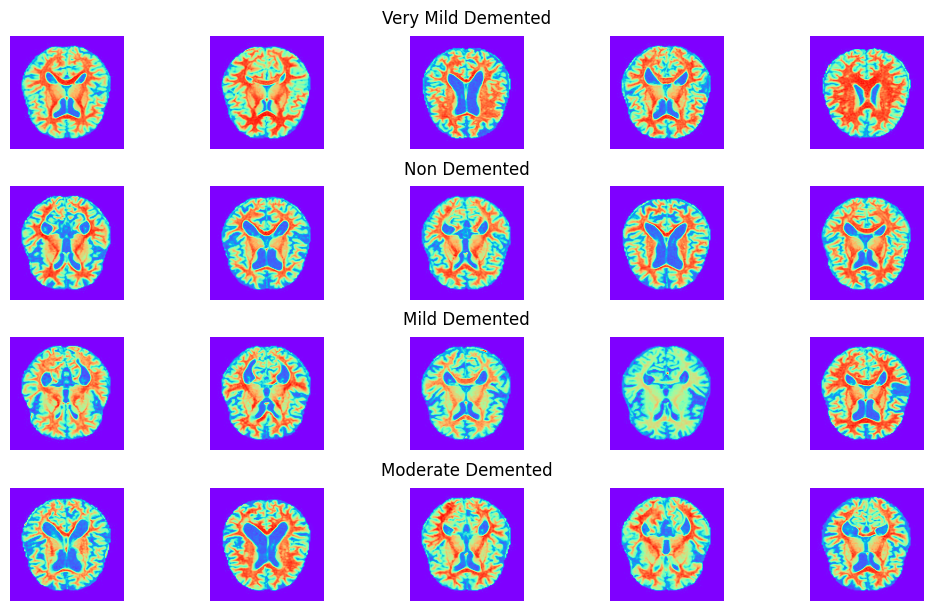

In [ ]:
plot_images(PATH, cmap='rainbow')

# Creating the dataset:

In [ ]:
# Assuming images are in a folder named "dataset" and labeled by subfolders
def load_images(path):
    images = []
    labels = []
    label = 0

    for subdir in os.listdir(path):
        subfolder = os.path.join(path, subdir)

        if os.path.isdir(subfolder):
            for filename in os.listdir(subfolder):

                img_path = os.path.join(subfolder, filename)
                img = cv.imread(img_path, cv.IMREAD_GRAYSCALE)

                if img is not None:
                    images.append(img)
                    labels.append(label) # you can append(subdir) if you want to have string labels

            label += 1

    return images, labels

In [ ]:
images, labels = load_images(PATH)

In [ ]:
images = torch.tensor(images, dtype=torch.float32).reshape([6400, 1, 128, 128])
labels = torch.tensor(labels, dtype=torch.long)

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(images,
                                                  labels,
                                                  test_size=0.2,
                                                  random_state=1984,
                                                  stratify=labels)

In [ ]:
train_ds = TensorDataset(X_train, y_train)
test_ds = TensorDataset(X_val, y_val)

In [ ]:
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=32, shuffle=True)

# AlexNet

In [320]:
class AlexNet(nn.Module):

  def __init__(self, num_classes=4):

    super().__init__()

    self.net = nn.Sequential(
        nn.LazyConv2d(96, kernel_size=11, stride=4, padding=1),
        nn.ReLU(), nn.MaxPool2d(kernel_size=3, stride=2),
        nn.LazyConv2d(256, kernel_size=5, padding=2), nn.ReLU(),
        nn.MaxPool2d(kernel_size=3, stride=2),
        nn.LazyConv2d(384, kernel_size=3, padding=1), nn.ReLU(),
        nn.LazyConv2d(384, kernel_size=3, padding=1), nn.ReLU(),
        nn.LazyConv2d(256, kernel_size=3, padding=1), nn.ReLU(),
        nn.MaxPool2d(kernel_size=3, stride=2), nn.Flatten(),
        nn.LazyLinear(4096), nn.ReLU(), nn.Dropout(p=0.5),
        nn.LazyLinear(4096), nn.ReLU(), nn.Dropout(p=0.5),
        nn.LazyLinear(num_classes)
    )

  def forward(self, X):
    return self.net(X)

model = AlexNet()

In [ ]:
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=.01, momentum=.9)

In [ ]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(train_loader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)

        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 100 == 99:    # print every 100 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 100:.3f}')
            running_loss = 0.0

print('Finished Training')

[1,   100] loss: 1.246
[2,   100] loss: 0.993
Finished Training


In [309]:
model_path = './model_path'

torch.save(model.state_dict(), model_path)

In [339]:
images, labels = next(iter(test_loader))

outputs = model(images)
_, predictions = torch.max(outputs, 1)

def plot_test_images(images, labels, predictions, cmap='gist_gray'):

  fig = plt.figure(layout='constrained', figsize=(10, 6))
  axes = fig.subplots(nrows=4, ncols=8)

  for i in range(4):
    axs = axes[i]

    for j, image in enumerate(images[8*i:8*(i+1)]):
      ax = axs[j]

      ax.axis('off')
      ax.imshow(image[0], cmap=cmap)
      title = labels[4*i + j].item(), predictions[4*i + j].item()
      ax.set_title(title)


In [340]:
model.load_state_dict(torch.load(model_path))

<All keys matched successfully>

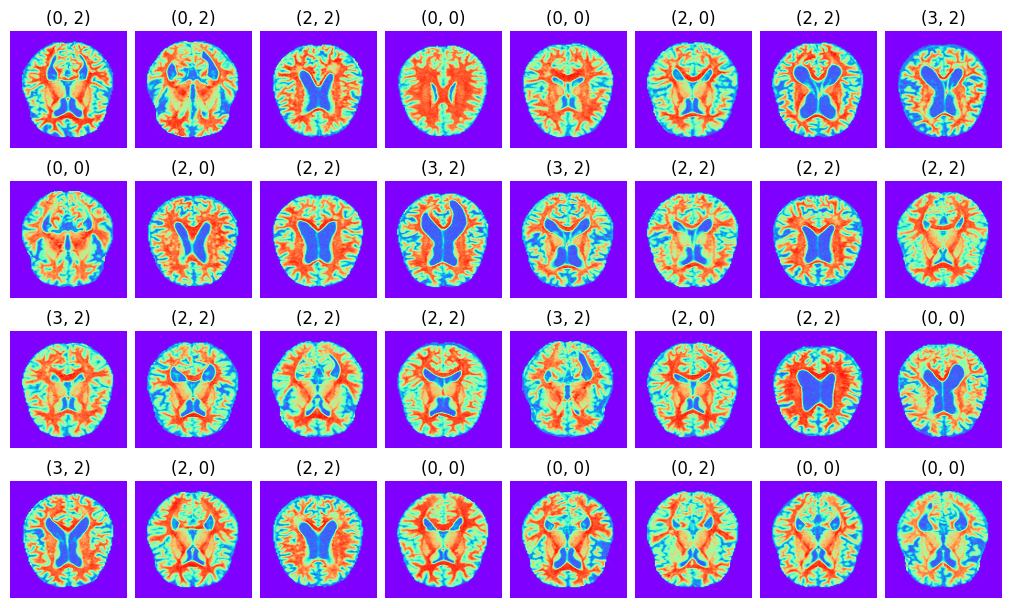

In [341]:
plot_test_images(images, labels, predictions, cmap='rainbow')

In [343]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = model(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 53 %


That's better than 25%!